# Importing Dependencies

### Instance Segmentation of Powder Particles and Satellites

This example is used to generate a visualization of an individual image


In [1]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

## Setting System Path

In [2]:
## ampis
ampis_root = Path('../../../')
sys.path.append(str(ampis_root))

from ampis import data_utils, visualize

In [3]:
EXPERIMENT_NAME = 'satellite' # can be 'particles' or 'satellite'
json_path_train = Path('..', 'data','via_2.0.8/', f'via_powder_{EXPERIMENT_NAME}_masks_training.json')  # path to training data
json_path_val = Path('..','data','via_2.0.8/', f'via_powder_{EXPERIMENT_NAME}_masks_validation.json')  # path to training data

assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'

cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
#cfg.DATASETS.TRAIN = (dataset_train,)  # dataset used for training model
#cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # we will look at the predictions on both sets after training
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 400  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 150  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = 2000  # maximum number of iterations to run during training
                            # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

    
    

## Establishing model Weights

In [11]:
# model weights will be downloaded if they are not present

weights_path = Path('..','..','..','examples','powder','satellite_output','model_final.pth')
#weights_path = Path('..','..','..','models','model_final_f10217.pkl')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.OUTPUT_DIR = str(Path('..', f'{EXPERIMENT_NAME}_output'))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
#cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
predictor = DefaultPredictor(cfg)  # create predictor object

Using locally stored weights: ../../../examples/powder/satellite_output/model_final.pth


### Importing image and visualizing


-------------------Print Tests----------------


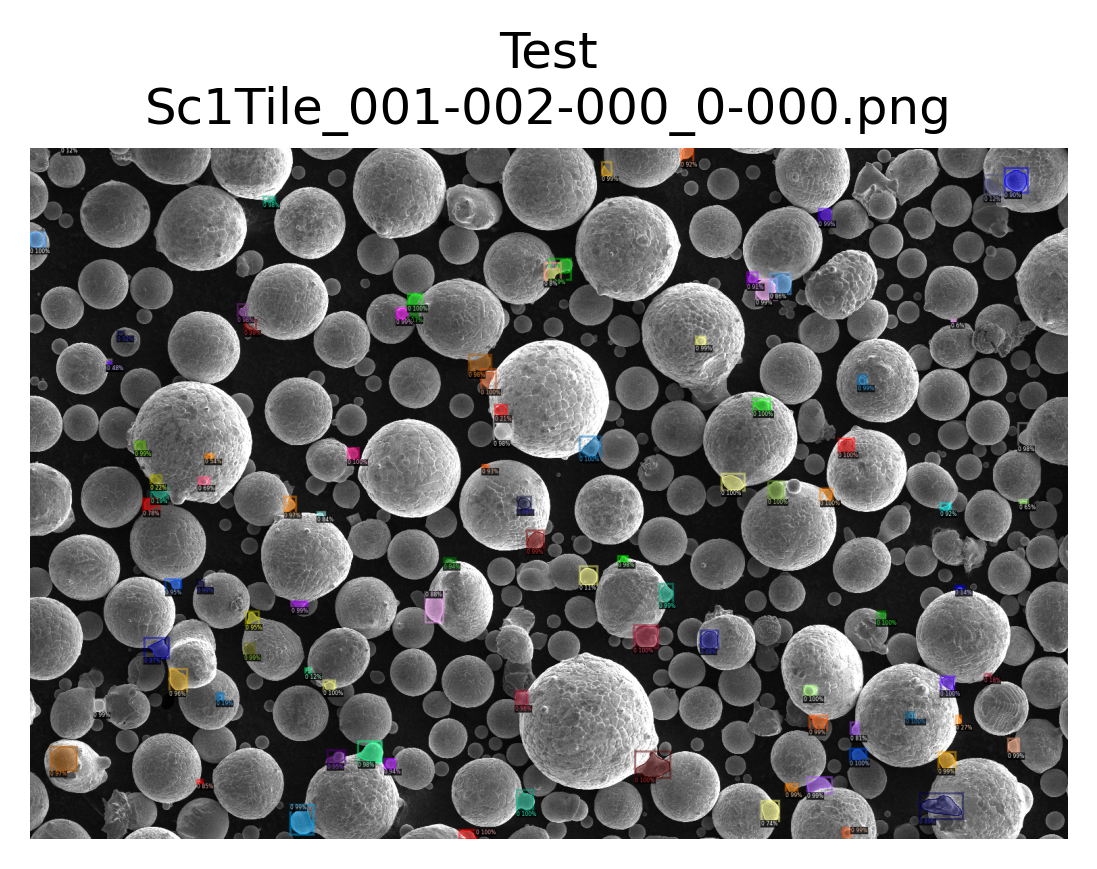

ddict info:
	path: ../data/images_png/Sc1Tile_001-002-000_0-000.png
	num_instances: 95


In [12]:
print("-------------------Print Tests----------------")
img_path = Path('..', 'data','images_png','Sc1Tile_001-002-000_0-000.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image

### Testing Again
Analyzing the same image with a the initial model made

Instances(num_instances=95, image_height=1024, image_width=1536, fields=[pred_boxes: [[8.13242310e+02 4.27524261e+02 8.43618103e+02 4.58303772e+02]
 [6.35061035e+02 1.01001630e+03 6.59570068e+02 1.02400000e+03]
 [8.95450989e+02 8.93886475e+02 9.46999878e+02 9.32565369e+02]
 [1.09164502e+03 4.93689728e+02 1.11522449e+03 5.21277222e+02]
 [1.07042822e+03 3.72187805e+02 1.09473352e+03 3.90941956e+02]
 [8.92893311e+02 7.06797485e+02 9.28568665e+02 7.40737793e+02]
 [4.70079926e+02 4.45465698e+02 4.86074982e+02 4.62401642e+02]
 [5.58513428e+02 2.16624435e+02 5.80207275e+02 2.34879227e+02]
 [4.34248505e+02 7.89365112e+02 4.50893433e+02 8.04189331e+02]
 [1.29611829e+03 8.36027222e+02 1.30803430e+03 8.46398010e+02]
 [1.34649902e+03 7.82573425e+02 1.36691150e+03 8.04864807e+02]
 [1.14466980e+03 7.96645081e+02 1.16337805e+03 8.13168213e+02]
 [1.16947009e+03 5.04590210e+02 1.18670117e+03 5.23287415e+02]
 [1.25311450e+03 6.87408752e+02 1.26546716e+03 7.00011719e+02]
 [7.20211548e+02 9.51437866e+02 7

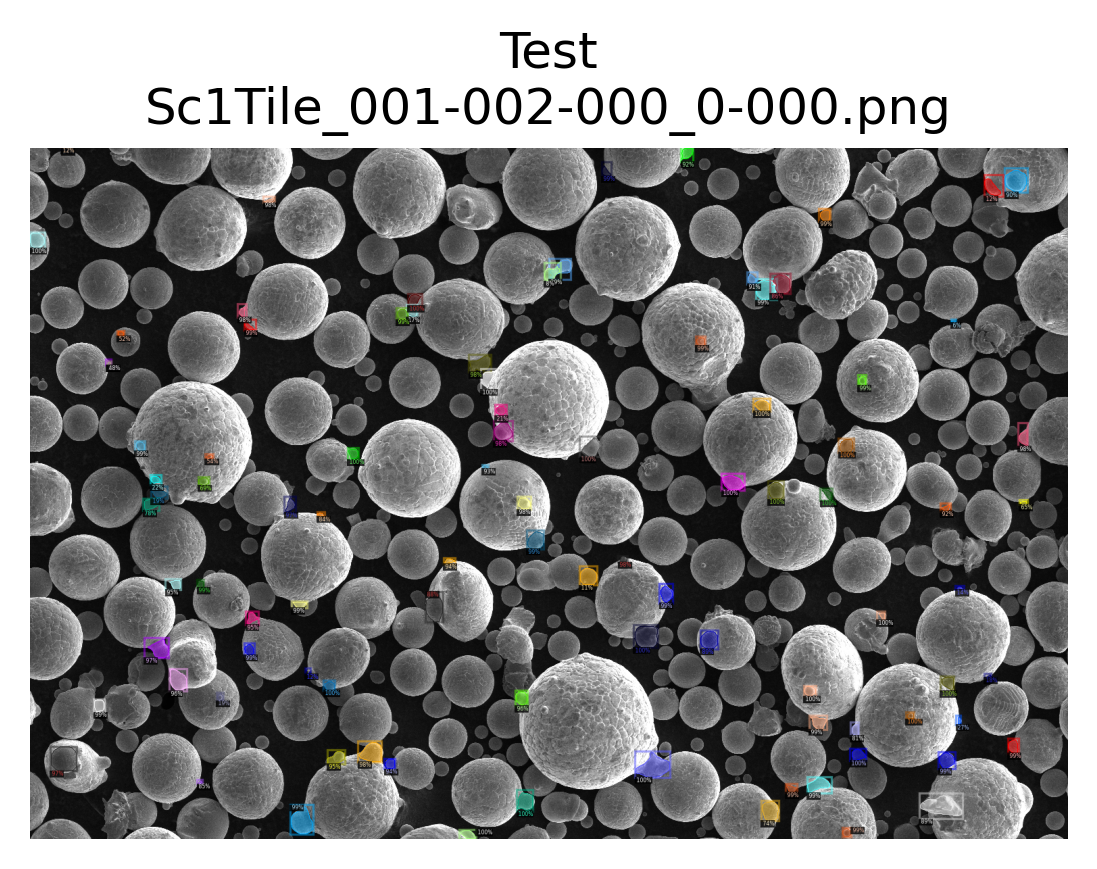

In [30]:
#------------------------------------
weights_path = Path('..','..','..','examples','powder','satellite_output_iteration1','model_final.pth')
cfg.MODEL.WEIGHTs = str(weights_path)
predictor = DefaultPredictor(cfg)  # create predictor object
outs = predictor(img)

data_utils.format_outputs(img_path, dataset='test', pred=outs)
print(outs['instances'])#['pred-masks'])
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=False)  #hides the end print statement